In [1]:
import sys
sys.path.insert(1, '../')
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from scipy.sparse import hstack
from concentration import ols, classical_ols_interval, pp_ols_interval
from tqdm import tqdm

from ols_utils import get_data, plot_data, transform_features, get_tree, make_plots

/Users/angelopoulos/miniconda3/envs/mai/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


## Interval Constructions

In [2]:
def trial(ols_features_2019, income_2019, predicted_income_2019, n, alpha, sandwich=True):
    X_labeled, X_unlabeled, Y_labeled, Y_unlabeled, Yhat_labeled, Yhat_unlabeled = train_test_split(ols_features_2019, income_2019, predicted_income_2019, train_size=n)
    X = np.concatenate([X_labeled, X_unlabeled],axis=0)

    Yhat = np.concatenate([Yhat_labeled, Yhat_unlabeled], axis=0)

    naive_interval = classical_ols_interval(X, Yhat, alpha, sandwich=sandwich)

    classical_interval = classical_ols_interval(X_labeled, Y_labeled, alpha, sandwich=sandwich)

    pp_interval = pp_ols_interval(X_labeled, X_unlabeled, Y_labeled, Yhat_labeled, Yhat_unlabeled, alpha, sandwich=sandwich)

    return naive_interval, classical_interval, pp_interval

## Monte Carlo Trials of Experiment

Classical coverage (0.86,0.94), prediction-powered (0.82,0.86)


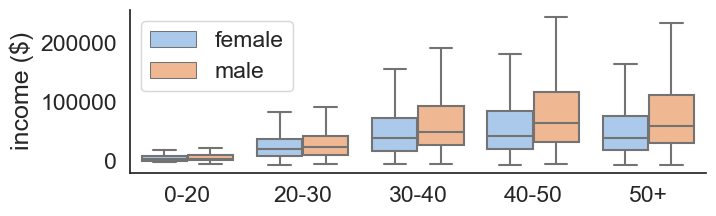

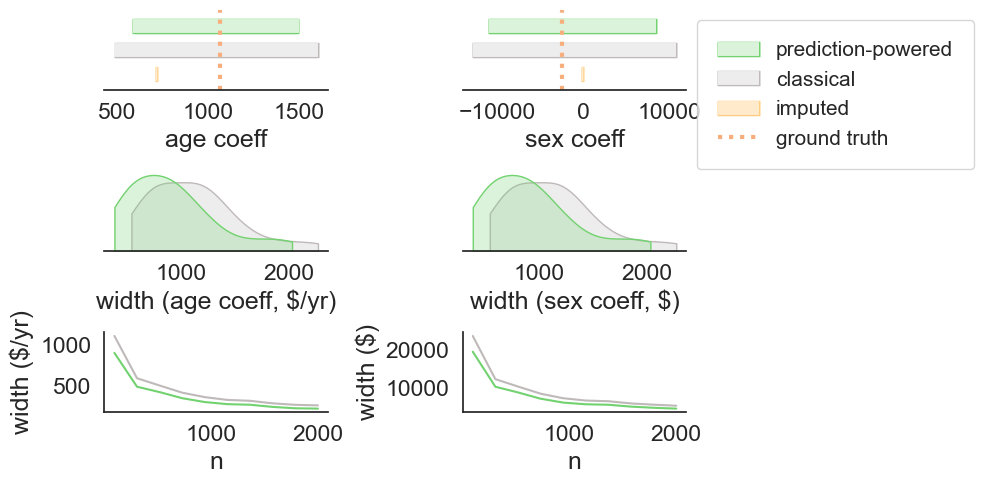

In [3]:
features = ['AGEP','SCHL','MAR','DIS','ESP','CIT','MIG','MIL','ANC1P','NATIVITY','DEAR','DEYE','DREM','SEX','RAC1P', 'SOCP', 'COW']
ft = np.array(["q", "q", "c", "c", "c", "c", "c", "c", "c", "c", "c", "c", "c", "c", "c", "c", "c"])
income_features_2019, income_2019, employed_2019 = get_data(year=2019, features=features, outcome='PINCP')
age_2019 = income_features_2019['AGEP'].to_numpy()
income_2019 = income_2019.to_numpy()
sex_2019 = income_features_2019['SEX'].to_numpy()
income_features_2019, enc = transform_features(income_features_2019, ft)
plot_data(age_2019[employed_2019], income_2019[employed_2019], sex_2019[employed_2019])

# OLS solution
ols_features_2019 = np.stack([age_2019, sex_2019], axis=1)
true = ols(ols_features_2019, income_2019)

try:
    df = pd.read_pickle('./.cache/ols-results.pkl')
except:
    # Train tree on 2018 data
    np.random.seed(0) # Fix seed for tree
    income_tree = get_tree(2018, features, ft, enc=enc)
    np.random.seed(0) # Fix seed for evaluation

    # Evaluate Tree
    predicted_income_2019 = income_tree.predict(xgb.DMatrix(income_features_2019))

    # Collect OLS features and do PPI
    print(f"True OLS coefficients: {true}")
    N = ols_features_2019.shape[0]
    num_n = 10
    ns = np.linspace(100, 2000, num_n).astype(int)
    num_trials = 50
    alpha = 0.05

    # Store results
    columns = ["lb","ub","covered","estimator","coefficient","n"]

    results = []
    for i in tqdm(range(num_trials)):
        for j in range(ns.shape[0]):
            n = ns[j]
            ii, ci, ppi = trial(ols_features_2019, income_2019, predicted_income_2019, n, alpha)
            temp_df = pd.DataFrame(np.zeros((6,len(columns))), columns=columns)
            temp_df.loc[0] = ii[0][0], ii[1][0], (ii[0][0] <= true[0]) & (true[0] <= ii[1][0]), "imputed", "age", n
            temp_df.loc[1] = ci[0][0], ci[1][0], (ci[0][0] <= true[0]) & (true[0] <= ci[1][0]), "classical", "age", n
            temp_df.loc[2] = ppi[0][0], ppi[1][0], (ppi[0][0] <= true[0]) & (true[0] <= ppi[1][0]), "prediction-powered", "age", n
            temp_df.loc[3] = ii[0][1], ii[1][1], (ii[0][1] <= true[1]) & (true[1] <= ii[1][1]), "imputed", "sex", n
            temp_df.loc[4] = ci[0][1], ci[1][1], (ci[0][1] <= true[1]) & (true[1] <= ci[1][1]), "classical", "sex", n
            temp_df.loc[5] = ppi[0][1], ppi[1][1], (ppi[0][1] <= true[1]) & (true[1] <= ppi[1][1]), "prediction-powered", "sex", n
            results += [temp_df]
    df = pd.concat(results)
    df["width"] = df["ub"] - df["lb"]
    df.to_pickle('./.cache/ols-results.pkl')
make_plots(df, true)